In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colormaps
from PIL import Image


Desenvolver uma ferramenta em Python que implemente e compare a eficácia de vários algoritmos de compressão aplicados a imagens. A ferramenta deve permitir compressão e descompressão de imagens em formatos como PNG e JPEG, além de comparar a eficiência dos algoritmos em termos de taxa de compressão e qualidade da imagem.

## Pré-processamento das imagens para compressão

In [13]:
def converter_escala_cinza(imagem):
    return imagem.convert('L')

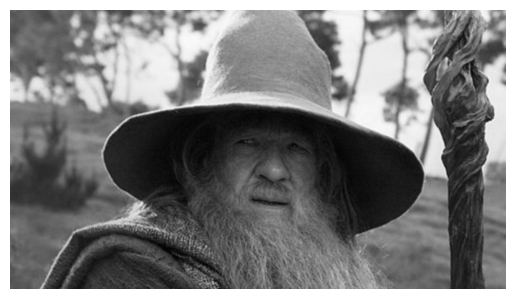

In [14]:
plt.imshow(converter_escala_cinza(Image.open("./example.jpg")), cmap=colormaps.get_cmap("gray"))
plt.axis('off')
plt.show()

## Implementar os Algoritmos de Compressão

In [15]:
imagem_cinza = converter_escala_cinza(Image.open("./example.jpg"))
## convert imagem_cinza to numpy array
mensagem = np.array(imagem_cinza).flatten()
imagem_shape = np.array(imagem_cinza).shape

### Compressão de Imagem com codificação aritmética

#### Codificando

Entradas:
- Mensagem

In [16]:
from decimal import Decimal
import decimal
decimal.getcontext().prec = 40

def get_probability_table(frequency_table):
    total_frequency = sum(list(frequency_table.values()))

    probability_table = {}
    for key, value in frequency_table.items():
        probability_table[key] = value / total_frequency

    return probability_table


def get_encoded_value(encoder):
    """
    After encoding the entire message, this method returns the single value that represents the entire message.
    """
    last_stage = list(encoder[-1].values())
    last_stage_values = []
    for sublist in last_stage:
        for element in sublist:
            last_stage_values.append(element)

    last_stage_min = min(last_stage_values)
    last_stage_max = max(last_stage_values)

    return (last_stage_min + last_stage_max) / 2


def process_stage(probability_table, stage_min, stage_max):
    """
    Processing a stage in the encoding/decoding process.
    """
    stage_probs = {}
    stage_domain = stage_max - stage_min
    for term_idx in range(len(probability_table.items())):
        term = list(probability_table.keys())[term_idx]
        term_prob = Decimal(probability_table[term])
        cum_prob = term_prob * stage_domain + stage_min
        stage_probs[term] = [stage_min, cum_prob]
        stage_min = cum_prob
    return stage_probs


def encode(msg, probability_table):
    encoder = []

    stage_min = Decimal(0.0)
    stage_max = Decimal(1.0)

    for msg_term_idx in range(len(msg)):
        stage_probs = process_stage(probability_table, stage_min, stage_max)

        msg_term = msg[msg_term_idx]
        stage_min = stage_probs[msg_term][0]
        stage_max = stage_probs[msg_term][1]

        encoder.append(stage_probs)

    stage_probs = process_stage(probability_table, stage_min, stage_max)
    encoder.append(stage_probs)

    encoded_msg = get_encoded_value(encoder)

    return encoder, encoded_msg


def decode(encoded_msg, msg_length, probability_table):
    decoder = []
    decoded_msg = ""

    stage_min = Decimal(0.0)
    stage_max = Decimal(1.0)

    for idx in range(msg_length):
        stage_probs = process_stage(probability_table, stage_min, stage_max)

        for msg_term, value in stage_probs.items():
            if value[0] <= encoded_msg <= value[1]:
                break

        decoded_msg = decoded_msg + msg_term
        stage_min = stage_probs[msg_term][0]
        stage_max = stage_probs[msg_term][1]

        decoder.append(stage_probs)

    stage_probs = process_stage(probability_table, stage_min, stage_max)
    decoder.append(stage_probs)

    return decoder, decoded_msg

In [17]:
frequency_table = {"a": 2,
                   "b": 3,
                   "c": 1,
                   "d": 4}

probability_table = get_probability_table(frequency_table)
original_msg = "abcdabcdaabdbd"
print("Original Message: {msg}".format(msg=original_msg))

encoder, encoded_msg = encode(msg=original_msg,
                              probability_table=probability_table)
print("Encoded Message: {msg}".format(msg=encoded_msg))

decoder, decoded_msg = decode(encoded_msg=encoded_msg,
                              msg_length=len(original_msg),
                              probability_table=probability_table)
print("Decoded Message: {msg}".format(msg=decoded_msg))

print("Message Decoded Successfully? {result}".format(result=original_msg == decoded_msg))

Original Message: abcdabcdaabdbd
Encoded Message: 0.07377673971712000533139191702503018767135
Decoded Message: abcdabcdaabdbd
Message Decoded Successfully? True


In [1]:
import numpy as np
from decimal import Decimal, getcontext
from collections import Counter

getcontext().prec = 40

def get_probability_table(frequency_table):
    total_frequency = sum(frequency_table.values())
    return {key: value / total_frequency for key, value in frequency_table.items()}

def process_stage(probability_table, stage_min, stage_max):
    stage_probs = {}
    stage_domain = stage_max - stage_min
    cum_prob = stage_min
    for term, term_prob in probability_table.items():
        next_cum_prob = cum_prob + Decimal(term_prob) * stage_domain
        stage_probs[term] = [cum_prob, next_cum_prob]
        cum_prob = next_cum_prob
    return stage_probs

def encode(msg, probability_table):
    stage_min, stage_max = Decimal(0.0), Decimal(1.0)
    for msg_term in msg:
        stage_probs = process_stage(probability_table, stage_min, stage_max)
        stage_min, stage_max = stage_probs[msg_term]
    encoded_msg = (stage_min + stage_max) / 2
    return encoded_msg

frequency_table = Counter(mensagem)
probability_table = get_probability_table(frequency_table)

# Encode the image data
encoded_msg = encode(msg=mensagem, probability_table=probability_table)
print("Encoded Message:", encoded_msg)

Encoded Message: 4.400734867353286145952564197324301530160E-7


In [2]:
def decode(encoded_msg, msg_length, probability_table):
    decoded_msg = []
    stage_min, stage_max = Decimal(0.0), Decimal(1.0)
    for _ in range(msg_length):
        stage_probs = process_stage(probability_table, stage_min, stage_max)
        for term, (term_min, term_max) in stage_probs.items():
            if term_min <= encoded_msg < term_max:
                decoded_msg.append(term)
                stage_min, stage_max = term_min, term_max
                break
    return np.array(decoded_msg, dtype=np.uint8)

In [3]:
decoded_msg = decode(encoded_msg=encoded_msg, msg_length=len(mensagem), probability_table=probability_table)

In [7]:
decoded_msg

array([ 98,  98,  97,  97,  98,  99, 101, 105, 106, 108, 108, 108, 108,
       107, 105, 103, 101,  99,  98,  98,  97], dtype=uint8)

In [10]:
mensagem.shape

(921600,)

In [9]:
decoded_msg.size

21

### Compressão de Imagem com Huffman 

### Compressão de Imagem com JPEG